In [1]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib as imp
import datacleaner
import datetime
imp.reload(datacleaner)

from datacleaner import *

2023-06-04 16:56:30.278931: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-04 16:56:30.348814: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-04 16:56:30.349436: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-04 16:56:31.826841: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
np.random.seed(1)
tf.keras.backend.clear_session()

bd = pd.read_csv(r"training_data.csv", na_filter=False)

In [3]:
timesteps = 24 #number of days that make up a sequence
univariate = 1 #number of features used by the model (using incidents to predict incidents)
multisteps = 24 #number of days to forecast – we will forecast the next 7 days
cv_splits = 3 #time series cross validator
epochs = 50
batch_size = 7 #7 sequences of 7 days - which corresponds to a window of 7 days in a batch

In [4]:
bd.head()

,city_name,magnitude_of_delay,delay_in_seconds,affected_roads,record_date,luminosity,avg_temperature,avg_atm_pressure,avg_humidity,avg_wind_speed,avg_precipitation,avg_rain,incidents
0,Guimaraes,UNDEFINED,0,",",2021-03-15 23:00,DARK,12.0,1013.0,70.0,1.0,0.0,Sem Chuva,None
1,Guimaraes,UNDEFINED,385,"N101,",2021-12-25 18:00,DARK,12.0,1007.0,91.0,1.0,0.0,Sem Chuva,None
2,Guimaraes,UNDEFINED,69,",",2021-03-12 15:00,LIGHT,14.0,1025.0,64.0,0.0,0.0,Sem Chuva,Low
3,Guimaraes,MAJOR,2297,"N101,R206,N105,N101,N101,N101,N101,N101,N101,N...",2021-09-29 09:00,LIGHT,15.0,1028.0,75.0,1.0,0.0,Sem Chuva,Very_High
4,Guimaraes,UNDEFINED,0,"N101,N101,N101,N101,N101,",2021-06-13 11:00,LIGHT,27.0,1020.0,52.0,1.0,0.0,Sem Chuva,High


In [5]:
def prepare_data(bd):
    bd = ordernar(bd)
    # bd = RoadsCleaner(bd)
    #bd = data(bd)
    # bd = valores_em_falta(bd)
    # bd = eliminar(bd)
    bd = incidentsNumbers(bd)
    # bd = luminosidade(bd)
    # bd = rainNumbers(bd)
    # bd = delayNumbers(bd)
    bd = removeOutlier(bd)
    bd.index = pd.to_datetime(bd["record_date"], format="%Y-%m-%d %H:%M:00")
    bd = bd[['incidents']]
    return bd

def data_normalization(bd, norm_range=(-1, 1)):
    scaler = MinMaxScaler(feature_range=norm_range)
    bd[['incidents']] = scaler.fit_transform(bd[['incidents']].values)
    return scaler

def to_supervised(df, timesteps):
    data = df.values
    X, y = list(), list()
    dataset_size = len(data)
    for curr_pos in range(dataset_size):
        input_index = curr_pos + timesteps
        label_index = input_index + 1

        if label_index < dataset_size:
            X.append(data[curr_pos:input_index,:])
            y.append(data[input_index:label_index, 0])
    
    return np.array(X).astype('float32'), np.array(y).astype('float32')

def split_data(bd, perc=10):
    train_idx = np.arange(0, int(len(bd)*(100-perc)/100))
    val_idx = np.arange(int(len(bd)*(100-perc)/100+1), len(bd))
    return train_idx, val_idx

In [6]:
bd = prepare_data(bd)

/home/diogofrosario/Desktop/trabalho-CSC/datacleaner.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd["delay_in_seconds"][count] = valor
/home/diogofrosario/Desktop/trabalho-CSC/datacleaner.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd["delay_in_seconds"][count] = valor
/home/diogofrosario/Desktop/trabalho-CSC/datacleaner.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bd["delay_in_seconds"][count] = valor
/home/d

In [7]:
bd.head()

,incidents
record_date,
2021-01-16 16:00:00,3
2021-01-16 18:00:00,2
2021-01-16 19:00:00,2
2021-01-16 20:00:00,2
2021-01-16 21:00:00,3


In [8]:
np.unique(bd.incidents)

array([0, 1, 2, 3, 4])

In [9]:
scaler = data_normalization(bd)
bd.head()

,incidents
record_date,
2021-01-16 16:00:00,0.5
2021-01-16 18:00:00,0.0
2021-01-16 19:00:00,0.0
2021-01-16 20:00:00,0.0
2021-01-16 21:00:00,0.5


In [10]:
temp = bd["incidents"]
temp = temp.resample("H").interpolate(method="time")
temp =temp[temp.index.month !=8]
print(temp)
bd = temp
bd.head()

record_date
2021-01-16 16:00:00    0.50
2021-01-16 17:00:00    0.25
2021-01-16 18:00:00    0.00
2021-01-16 19:00:00    0.00
2021-01-16 20:00:00    0.00
                       ... 
2021-12-31 19:00:00   -1.00
2021-12-31 20:00:00   -1.00
2021-12-31 21:00:00   -1.00
2021-12-31 22:00:00   -1.00
2021-12-31 23:00:00   -1.00
Name: incidents, Length: 7640, dtype: float64


record_date
2021-01-16 16:00:00    0.50
2021-01-16 17:00:00    0.25
2021-01-16 18:00:00    0.00
2021-01-16 19:00:00    0.00
2021-01-16 20:00:00    0.00
Name: incidents, dtype: float64

In [11]:
len(bd)

7640

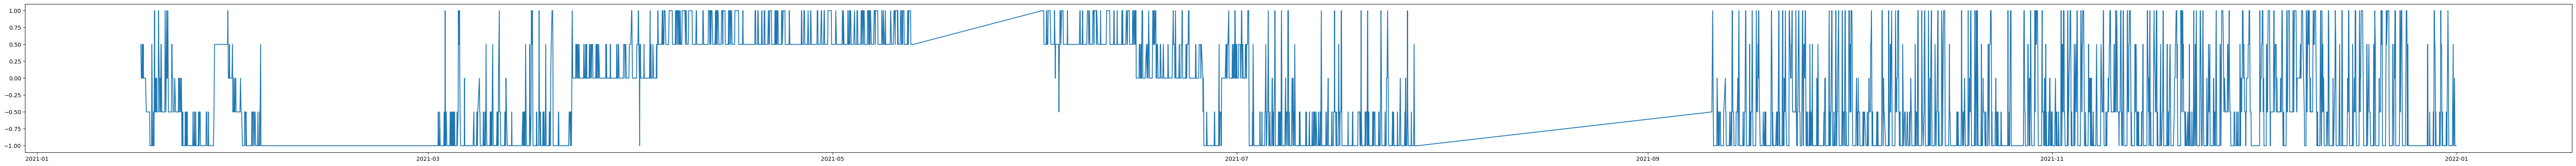

In [12]:
fig=plt.figure()
plt.plot(bd)
spacing =10
fig.subplots_adjust(right=spacing)
plt.show()

In [13]:
bd = bd.to_frame(name='incidents')

In [14]:
X, y = to_supervised(bd, timesteps)
X.shape, y.shape

((7615, 24, 1), (7615, 1))

In [15]:
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [16]:
def rmse(y_true, y_pred):
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

def build_model(timesteps, features, filters=16, kernel_size=5, pool_size=2):
    #using the Functional API
    inputs = tf.keras.layers.Input(shape=(timesteps, features))
    print(inputs)
    #microarchitecture
    x = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size,
    activation='relu', data_format='channels_last')(inputs)
    x = tf.keras.layers.AveragePooling1D(pool_size=pool_size,
    data_format='channels_first')(x)
    #last layers
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(filters)(x)
    outputs = tf.keras.layers.Dense(1)(x)
    #the model
    cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='KaggleCNN_model')
    tf.keras.utils.plot_model(cnnModel, 'Kagglecnn.png', show_shapes=True)
    return cnnModel

def plot_learning_curves(history, epochs):
    #accuracies and losses
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    #creating figure
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training/Validation Accuracy')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training/Validation Loss')
    plt.show()

def plot_train_data(data, approach='history'):
    plt.figure(figsize=(8,6))
    if approach == 'history':
        plt.title('Model train vs val loss per Training Split')
        plt.ylabel('Training RMSE (Normalized)')
        plt.xlabel('Epoch')
        for hist, i in zip(data, range(len(data))):  
            plt.subplot(3,1,i+1)      
            plt.plot(hist.epoch, hist.history['loss'])
            plt.plot(hist.epoch, hist.history['val_loss'])
            plt.xlim([0, max(hist.epoch)])  
            plt.legend(['Training split ' + str(i+1) + ' - train loss', 'Training split ' + str(i+1) + ' - val loss'], loc='upper right')
        plt.show()   
    elif approach == 'loss':
        plt.figure(figsize=(6,3))
        plt.plot(range(len(data)), data)
        plt.title('RMSE value per Timeseries split')
        plt.ylabel('Evaluation RMSE')
        plt.xlabel('Timeseries Splits')
        plt.xlim([0, 2])
        plt.ylim([0, (np.amax(data)+2)])
        plt.show()

def compile_and_fit(model, epochs, batch_size):
    #compile
    model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
    #fit
    hist_list = list()
    loss_list = list()
    #Time Series Cross Validator
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    for train_index, test_index in tscv.split(X):
        train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
        #build data
        X_train, y_train = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]
        X_test, y_test = X[test_index], y[test_index]
        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
        epochs=epochs, batch_size=batch_size, shuffle=False)
        metrics = model.evaluate(X_test, y_test)
        hist_list.append(history)
        loss_list.append(metrics[2])
    plot_train_data(hist_list, approach='history')
    # plot_learning_curves(loss_list, approach='loss')
    return model, hist_list, loss_list

def forecast(model, df, timesteps, multisteps, scaler):
    input_seq = df[-timesteps:].values #getting the last sequence of known value
    inp = input_seq
    predictions = list()
    for _ in range(1, multisteps+1):
        inp = inp.reshape(1, timesteps, 1)
        yhat = model.predict(inp)
        yhat_inversed = scaler.inverse_transform(yhat)
        predictions.append(yhat_inversed[0][0])
        #prepare new input to forecast the next day
        inp = np.append(inp[0], yhat)
        inp = inp[-timesteps:]
    return predictions

def plot_forecast(data, forecasts):
    plt.figure(figsize=(8,6))
    plt.plot(range(len(data)), data, color='green', label='Confirmed')
    plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
    plt.title('Number of incidents')
    plt.ylabel('Incidents')
    plt.xlabel('Days')
    plt.legend()
    plt.show()    

In [17]:
model = build_model(timesteps, univariate)

KerasTensor(type_spec=TensorSpec(shape=(None, 24, 1), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")


Epoch 1/50
245/245 [==============================] - 2s 5ms/step - loss: 0.2584 - mae: 0.2262 - rmse: 0.2584 - val_loss: 0.3199 - val_mae: 0.2804 - val_rmse: 0.3321
Epoch 2/50
245/245 [==============================] - 1s 3ms/step - loss: 0.2109 - mae: 0.1748 - rmse: 0.2109 - val_loss: 0.2770 - val_mae: 0.2372 - val_rmse: 0.2769
Epoch 3/50
245/245 [==============================] - 1s 2ms/step - loss: 0.1973 - mae: 0.1649 - rmse: 0.1973 - val_loss: 0.2224 - val_mae: 0.1845 - val_rmse: 0.2183
Epoch 4/50
245/245 [==============================] - 1s 3ms/step - loss: 0.1827 - mae: 0.1495 - rmse: 0.1827 - val_loss: 0.2080 - val_mae: 0.1687 - val_rmse: 0.2037
Epoch 5/50
245/245 [==============================] - 1s 3ms/step - loss: 0.1750 - mae: 0.1409 - rmse: 0.1750 - val_loss: 0.2016 - val_mae: 0.1668 - val_rmse: 0.1967
Epoch 6/50
245/245 [==============================] - 1s 2ms/step - loss: 0.1673 - mae: 0.1344 - rmse: 0.1673 - val_loss: 0.2395 - val_mae: 0.2045 - val_rmse: 0.2421
Epoc

/tmp/ipykernel_106539/2339410507.py:50: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,1,i+1)


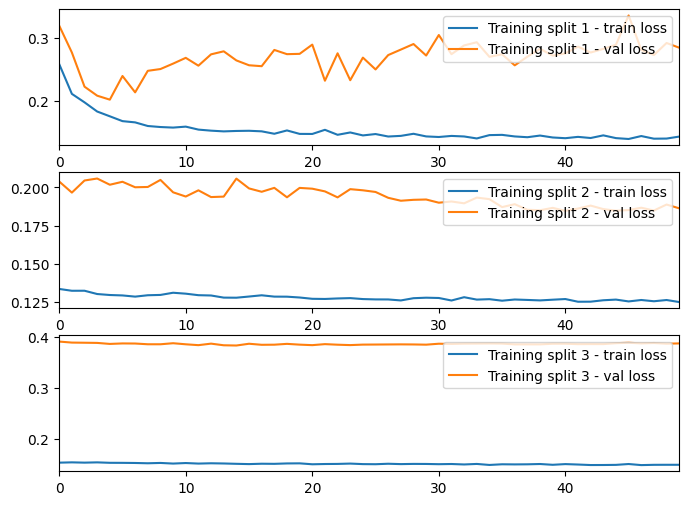

In [18]:
model, hist_list, loss_list = compile_and_fit(model, epochs, batch_size)

1/1 [==============================] - 0s 27ms/step


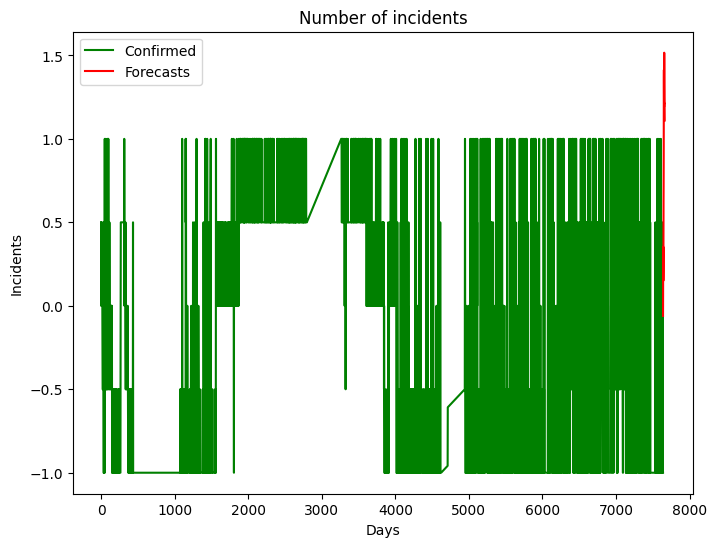

In [19]:
forecasts = forecast(model, bd, timesteps, multisteps, scaler)
plot_forecast(bd, forecasts)

In [20]:
forecasts

[-0.06042576,
 0.07242918,
 0.31256652,
 0.3532802,
 0.15015733,
 0.20788896,
 0.39093864,
 0.62734866,
 0.71734846,
 0.86111367,
 1.0466142,
 1.3434424,
 1.4133294,
 1.291373,
 1.1917183,
 1.2811286,
 1.5160438,
 1.5117621,
 1.3659403,
 1.2475646,
 1.2114573,
 1.2118986,
 1.171747,
 1.1101072]

In [21]:
model.compile(loss=rmse, optimizer=tf.keras.optimizers.Adam(), metrics=['mae', rmse])
model.fit(X, y, epochs=epochs, batch_size=batch_size, shuffle=False)

Epoch 1/50
1088/1088 [==============================] - 3s 2ms/step - loss: 0.2198 - mae: 0.1682 - rmse: 0.2198
Epoch 2/50
1088/1088 [==============================] - 2s 2ms/step - loss: 0.2189 - mae: 0.1680 - rmse: 0.2189
Epoch 3/50
1088/1088 [==============================] - 2s 2ms/step - loss: 0.2181 - mae: 0.1672 - rmse: 0.2181
Epoch 4/50
1088/1088 [==============================] - 2s 2ms/step - loss: 0.2178 - mae: 0.1672 - rmse: 0.2178
Epoch 5/50
1088/1088 [==============================] - 3s 2ms/step - loss: 0.2172 - mae: 0.1668 - rmse: 0.2172
Epoch 6/50
1088/1088 [==============================] - 2s 2ms/step - loss: 0.2166 - mae: 0.1663 - rmse: 0.2166
Epoch 7/50
1088/1088 [==============================] - 2s 2ms/step - loss: 0.2163 - mae: 0.1663 - rmse: 0.2163
Epoch 8/50
1088/1088 [==============================] - 3s 2ms/step - loss: 0.2163 - mae: 0.1665 - rmse: 0.2164
Epoch 9/50
1088/1088 [==============================] - 3s 2ms/step - loss: 0.2158 - mae: 0.1657 - rmse:

In [22]:
# plot_learning_curves(hist_list, epochs)

In [23]:
forecasts = forecast(model, bd, timesteps, multisteps, scaler)

1/1 [==============================] - 0s 32ms/step


In [24]:
print(forecasts)

[-0.36530137, -0.31372404, -0.16633606, -0.060909986, -0.011839867, 0.06410241, 0.19622827, 0.19802034, 0.29968834, 0.48373842, 0.79600453, 1.2583467, 1.3308063, 0.877524, 0.66110766, 0.6587398, 0.6577877, 0.5668733, 0.3834604, 0.32471895, 0.32711196, 0.3058722, 0.24022233, 0.18120241]


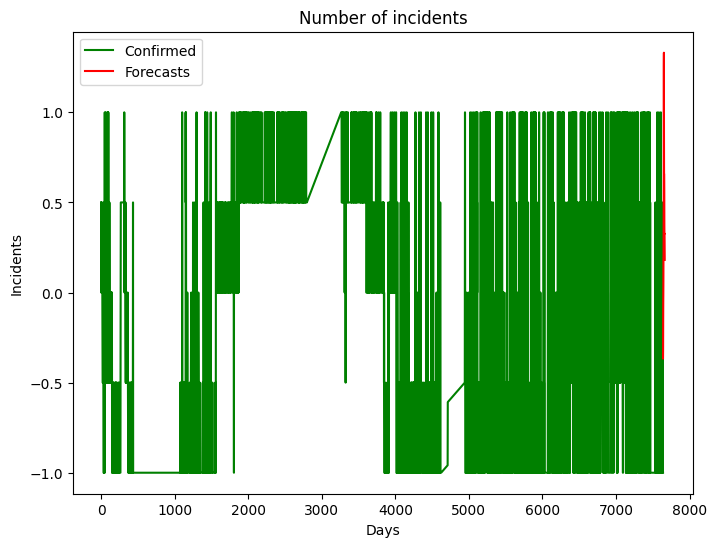

In [25]:
plot_forecast(bd, forecasts)